In [44]:
## Setting or importing API key from env var.

# import getpass  ## This hides the password as we type it.
# import os

# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")

# _set_env("API_KEY")

## Part1: Getting Started, creating LLM app with Groq's LLM.

In [45]:
from typing import Annotated
## Used to attach metadata to a type. In this case, it helps specify how updates to a particular state key should be handled.

from typing_extensions import TypedDict
## A way to define dictionary types with fixed keys and corresponding value types. It ensures that the state follows a specific structure.

from langgraph.graph import StateGraph, START, END

from langgraph.graph.message import add_messages
## A function (or callable) that defines how to update the messages field in the state. The comment clarifies that instead of overwriting the list of messages, this function appends new messages.


class State(TypedDict):
    messages: Annotated[list, add_messages]
    """
    This defines a dictionary where the key "messages" must hold a list. Using TypedDict ensures that any state adhering to this structure will have a consistent format.
    The type of messages is list, but it is enhanced with the metadata add_messages. This means when the system updates the messages key, it should use the add_messages function. Essentially, if new messages are added, they’ll be appended to the existing list rather than replacing it.
    """

graph_builder = StateGraph(State)

In [46]:
from langchain_groq import ChatGroq
from groq import Groq
from dotenv import load_dotenv
import os

load_dotenv()
client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

llm = ChatGroq(model="llama3-70b-8192")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever the node is used.
graph_builder.add_node("chatbot", chatbot)

In [47]:
# Next, add an entry point. This tells our graph where to start its work each time we run it.
graph_builder.add_edge(START, "chatbot")

In [48]:
# Similarly, set a finish point. This instructs the graph "any time this node is run, you can exit."
graph_builder.add_edge("chatbot", END)

In [49]:
# we'll want to be able to run our graph. To do so, call "compile()" on the graph builder. This creates a "CompiledGraph" we can use invoke on our state.
graph = graph_builder.compile()

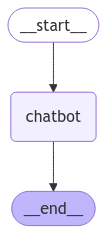

In [50]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [51]:
## Now let's run the chatbot!
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:  # noqa: E722
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: What do you know about LangGraph?
Assistant: LangGraph! That's a fascinating topic. LangGraph is an open-source, graph-based language model that has gained significant attention in the natural language processing (NLP) community. Here's what I know about it:

**What is LangGraph?**

LangGraph is a novel approach to language modeling that represents language as a graph structure, rather than the traditional sequential approach used in most language models. This graph-based representation allows LangGraph to capture complex relationships between words, entities, and concepts in a more nuanced and flexible way.

**Key Features:**

1. **Graph-based representation**: LangGraph represents language as a graph, where nodes correspond to words, entities, or concepts, and edges represent relationships between them.
2. **Contextualized embeddings**: LangGraph uses contextualized embeddings, which capture the meaning of a word based on its context, rather than a fixed embedding.
3. **Multi-h

## Part2: Adding and making use of Tools to the LLM App! like Search tool- Tavily.

In [ ]:
# _set_env("TAVILY_API_KEY")
from tavily import TavilyClient

tavily_client = TavilyClient(api_key="tvly-YOUR_API_KEY")

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'title': "Beginner's Guide to LangGraph: Understanding State, Nodes, and ...",
  'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
  'content': "Beginner’s Guide to LangGraph: Understanding State, Nodes, and Edges — Part 1 | by Kamal Dhungana | Medium Beginner’s Guide to LangGraph: Understanding State, Nodes, and Edges — Part 1 LangGraph — State, Node and Edge Explained Mainly, we will focus on various components of LangGraph: State, Node, and Edges, and how to build a complete graph from these components. Once we understand these components, we will be able to build relatively complex LangGraph-based agents. Each node represents a specific function or operation that processes the current state. Nodes can perform computations, modify the state, or generate outputs based on the input they receive. Follow 1.2K Followers Data scientist with a passion for AI, Regularly blogging about LLM and OpenAI's innovations,Sh

In [ ]:
## Created new graph:
workflow = StateGraph(State)

llm = ChatGroq(model="llama3-70b-8192")

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot_new(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


workflow.add_node("chatbot", chatbot_new)


Next we need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

Below, we implement a BasicToolNode that checks the most recent message in the state and calls tools if the message contains tool_calls.

It relies on the LLM's tool_calling support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

We will later replace this with LangGraph's prebuilt ToolNode to speed things up, but building it ourselves first is instructive.

In [ ]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}  ## Creates a dictionary mapping each tool’s name to the tool itself. This allows quick lookup when processing a tool call.

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):  ## Walrus operator to assign and check if there are any messages.
            message = messages[-1]  # Retrieves the last message from the list
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
workflow.add_node("tools", tool_node)

In [ ]:
def route_tools(state: State,):
    ## Use in the conditional_edge to route to the ToolNode if the last message has tool calls. Otherwise, route to the end."
    
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.

workflow.add_conditional_edges("chatbot",route_tools,{"tools": "tools", END: END})
    # The above dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"


# Any time a tool is called, we return to the chatbot to decide the next step
workflow.add_edge("tools", "chatbot")
workflow.add_edge(START, "chatbot")
graph2 = workflow.compile()

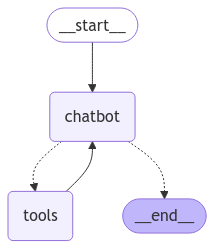

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph2.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
## Now we can ask the bot questions outside its training data.
def stream_graph_updates2(user_input: str):
    for event in graph2.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates2(user_input)
    except:  #noqa
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates2(user_input)
        break

Assistant: 
Assistant: [{"title": "langchain-ai/langgraph: Build resilient language agents as graphs.", "url": "https://github.com/langchain-ai/langgraph", "content": "GitHub - langchain-ai/langgraph: Build resilient language agents as graphs. LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Let's build a tool-calling ReAct-style agent that uses a search tool! The simplest way to create a tool-calling agent in LangGraph is to use create_react_agent: Define the tools for the agent to use Define the tools for the agent to use This means that after tools is called, agent node is called next. workflow.add_edge(\"tools\", 'agent') Normal edge: after the tools are invoked, the graph should always return to the agent to decide what to do next LangGraph adds the input message to the internal state, then passes the state to the entrypoint node, \"agent\".", "score": 0.8987045}, {"title": "LangGraph - LangChain", "u

## Part 3: Adding Memory to the Chatbot

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [ ]:
from langgraph.prebuilt import ToolNode, tools_condition

workflow2 = StateGraph(State)


workflow2.add_node("chatbot", chatbot_new)

tool_node = ToolNode(tools=[tool])
workflow2.add_node("tools", tool_node)

workflow2.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
workflow2.add_edge("tools", "chatbot")
workflow2.add_edge(START, "chatbot")

In [ ]:
graph3 = workflow2.compile(checkpointer=memory)

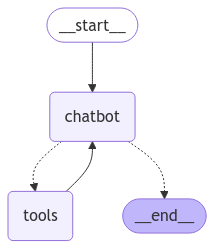

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph3.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now you can interact with your bot! First, pick a thread to use as the key for this conversation.

In [ ]:
config = {"configurable": {"thread_id": "1"}}

Next, call your chat bot.

In [ ]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph3.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

<tool-use>{"tool_calls": []}</tool-use>


Let's ask a followup: see if it remembers your name.

In [ ]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph3.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, your name is Will.


Don't believe me? Try this using a different config.

In [ ]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph3.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_vtqt)
 Call ID: call_vtqt
  Args:
    query: Remember my name
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Remember My Name (film) - Wikipedia", "url": "https://en.wikipedia.org/wiki/Remember_My_Name_(film)", "content": "Remember My Name (film) The Washington Post described the film as a \"neurotic film noir\" that is also a \"gripping tale of sexual frustration.\" The reviewer was also impressed with Chaplin's performance: \"Chaplin is spooky, spookier even than Perkins, in this complex performance as a woman who's painfully adjusting to freedom.\"[7] Jack Kroll of Newsweek praised Rudolph's direction: \"he has a real eye for the visual paradox, the elegant and even beautiful form

By now, we have made a few checkpoints across two different threads. But what goes into a checkpoint? To inspect a graph's state for a given config at any time, call get_state(config).

In [ ]:
snapshot = graph3.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='c7f0fdab-a47d-46cd-8426-f67b114f019c'), AIMessage(content='<tool-use>{"tool_calls": []}</tool-use>', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 947, 'total_tokens': 960, 'completion_time': 0.08025211, 'prompt_time': 0.044017926, 'queue_time': 0.247897684, 'total_time': 0.124270036}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_2e0feca3c9', 'finish_reason': 'stop', 'logprobs': None}, id='run-d5cdfee0-1b73-42bf-aaa8-ece21422ca9c-0', usage_metadata={'input_tokens': 947, 'output_tokens': 13, 'total_tokens': 960}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='db485cb1-5a39-4f2d-aa00-7c600002f6c3'), AIMessage(content='Yes, your name is Will.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 973, 't

In [ ]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()

## Part 4: Human-in-the-Loop

LangGraph's persistence layer supports human-in-the-loop workflows, allowing execution to pause and resume based on user feedback.

The primary interface to this functionality is the interrupt function.

Calling interrupt inside a node will pause execution. Execution can be resumed, together with new input from a human, by passing in a Command.

interrupt is ergonomically similar to Python's built-in input(), with some caveats.

In [ ]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

from langchain_groq import ChatGroq
from groq import Groq
from dotenv import load_dotenv
import os

load_dotenv()
client = Groq(api_key=os.environ.get("GROQ_API_KEY"))


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = ChatGroq(model="llama3-70b-8192")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [ ]:
## compile the graph with a checkpointer:
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

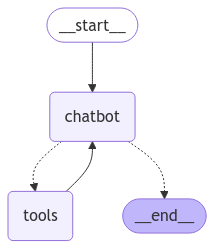

In [ ]:
## Displaying the Graph Workflow:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Let's now prompt the chatbot with a question that will engage the new human_assistance tool:

In [ ]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_qc4r)
 Call ID: call_qc4r
  Args:
    query: I need some expert guidance for building an AI agent.


The chatbot generated a tool call, but then execution has been interrupted! Note that if we inspect the graph state, we see that it stopped at the tools node:

In [ ]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

Let's take a closer look at the human_assistance tool:

To resume execution, we pass a Command object containing data expected by the tool. The format of this data can be customized based on our needs. Here, we just need a dict with a key "data":

In [ ]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_qc4r)
 Call ID: call_qc4r
  Args:
    query: I need some expert guidance for building an AI agent.
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

Thank you for providing the tool call result. Based on the expert's guidance, I'll respond directly without using another tool. Here's my response:

That's great advice! LangGraph does seem like a reliable and extensible platform for building AI agents. What specific features or functionalities are you looking to implement in your agent?


## Part 5: Customizing State

So far, we've relied on a simple state with one entry-- a list of messages. You can go far with this simple state, but if you want to define complex behavior without relying on the message list, you can add additional fields to the state. Here we will demonstrate a new scenario, in which the chatbot is using its search tool to find specific information, and forwarding them to a human for review. Let's have the chatbot research the birthday of an entity. We will add name and birthday keys to the state:

In [64]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

In [65]:
from langchain_core.messages import ToolMessage  # noqa: F811
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt  # noqa: F811


@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not be revealed to the model in the tool's schema.
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

In [66]:
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_groq import ChatGroq
from groq import Groq
from dotenv import load_dotenv
import os

load_dotenv()
client = Groq(api_key=os.environ.get("GROQ_API_KEY"))
llm = ChatGroq(model="llama3-70b-8192")
tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]

llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

Let's prompt our application to look up the "birthday" of the LangGraph library. We will direct the chatbot to reach out to the human_assistance tool once it has the required information. Note that setting name and birthday in the arguments for the tool, we force the chatbot to generate proposals for these fields.

In [67]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_sce6)
 Call ID: call_sce6
  Args:
    name: LangGraph release date
    birthday: N/A


We've hit the interrupt in the human_assistance tool again. In this case, the chatbot failed to identify the correct date, so we can supply it:

In [68]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_sce6)
 Call ID: call_sce6
  Args:
    name: LangGraph release date
    birthday: N/A
================================= Tool Message =================================
Name: human_assistance

Made a correction: {'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}
================================== Ai Message ==================================

So, LangGraph was released on January 17, 2024.


Note that these fields are now reflected in the state:

In [69]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}

This makes them easily accessible to downstream nodes (e.g., a node that further processes or stores the information).

### Manually updating state

LangGraph gives a high degree of control over the application state. For instance, at any point (including when interrupted), we can manually override a key using graph.update_state:

In [70]:
graph.update_state(config, {"name": "LangGraph (library)"})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1effa8a7-05d5-6526-8004-83c08e3abe1c'}}

If we call graph.get_state, we can see the new value is reflected:

In [71]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph (library)', 'birthday': 'Jan 17, 2024'}

Manual state updates will even generate a trace in LangSmith. If desired, they can also be used to control human-in-the-loop workflows, as described in this guide. Use of the interrupt function is generally recommended instead, as it allows data to be transmitted in a human-in-the-loop interaction independently of state updates.